In [24]:
import pandas as pd
import seaborn as sns

In [25]:
ref=pd.read_pickle("../01_preparation/all_runs/pb_augustus_sqanti.pkl")

In [26]:
ref

,gene,isoform,accession,associated_gene,associated_transcript,exons,length,isoform_read_support,gene_read_support,structural_category,subcategory,Sqanti_ORF_seq
0,PB.1,PB.1.1,at6923,g2,novel,9,849,1,2,novel_not_in_catalog,at_least_one_novel_splicesite,MAASEHRCVGCGFRVKSLFIQYSPGNIRLMKCGNCKEVADEYIECE...
1,PB.1,PB.1.2,at6923,g2,novel,6,1381,1,2,novel_not_in_catalog,intron_retention,MAASEHRCVGCGFRVKSLFIQYSPGNIRLMKCGNCKEVADEYIECE...
2,PB.10,PB.10.1,at6923,novelGene_g8_AS,novel,1,1804,1,1,antisense,mono-exon,NaN
3,PB.100,PB.100.1,at6923,g132,novel,11,1387,1,22,novel_not_in_catalog,at_least_one_novel_splicesite,MGAWLYFKYHGVVTQECDPYFDNTGCSHPGCEPTYPTPKCERKCVS...
4,PB.100,PB.100.10,at6923,g132,novel,10,1274,2,22,novel_not_in_catalog,at_least_one_novel_splicesite,MGAWLYFKYHGVVTQECDPYFDNTGCSHPGCEPTYPTPKCERKCVS...
...,...,...,...,...,...,...,...,...,...,...,...,...
268790,PB.16388,PB.16388.66,col0,novelGene_2429,novel,3,990,1,81,intergenic,multi-exon,NaN
268791,PB.16388,PB.16388.7,col0,ATMG01370,novel,19,2828,1,81,genic,multi-exon,NaN
268792,PB.16388,PB.16388.8,col0,ATMG01370,novel,3,2774,1,81,genic,multi-exon,NaN
268793,PB.16388,PB.16388.9,col0,ATMG01370,novel,3,2762,1,81,genic,multi-exon,NaN


In [41]:
len(ref)

5538733

In [46]:
ref["isoform_read_support"].sum()

10131655

In [42]:
ref["isoform_read_support"].value_counts()

1       4728718
2        375069
3        145212
4         76202
5         46495
         ...   
1128          1
1070          1
577           1
478           1
223           1
Name: isoform_read_support, Length: 903, dtype: int64

In [45]:
ref.loc[ref["accession"]=="at9900"]["isoform_read_support"].value_counts(normalize=True)

1      0.854066
2      0.067308
3      0.025855
4      0.013814
5      0.008479
         ...   
375    0.000003
233    0.000003
211    0.000003
370    0.000003
343    0.000003
Name: isoform_read_support, Length: 278, dtype: float64

In [27]:
# add new column
ref["cat_assign"]="None"
# and fill new colum based on 4 categories
ref.loc[(ref["structural_category"] != "antisense") & (ref["structural_category"] != "fusion") & (ref["structural_category"] != "intergenic"), "cat_assign"]="one2one"
ref.loc[(ref["structural_category"] == "antisense"), "cat_assign"]="antisense"
ref.loc[(ref["structural_category"] == "fusion"), "cat_assign"]="fusion"
ref.loc[((ref["structural_category"] == "intergenic") | (ref["structural_category"] == "genic_intron")), "cat_assign"]="novel"

# in some cases, fusion transcripts were reported as one2one if they had perfect splice junctions over their fusion genes.
# filter them and add replace the assignment
ref["association"] = ref["associated_gene"].str.split("_").str.len()
ref.loc[(ref["cat_assign"]=="one2one")&(ref["association"]>1), "cat_assign"] = "fusion"

In [28]:
ref=ref.loc[(ref["cat_assign"]=="one2one")|(ref["cat_assign"]=="fusion")]

In [29]:
order=['reference_match','alternative_3end','alternative_5end','alternative_3end5end',
       '3prime_fragment','5prime_fragment','internal_fragment','multi-exon',
       'intron_retention',
       'combination_of_known_junctions','combination_of_known_splicesites','mono-exon_by_intron_retention','at_least_one_novel_splicesite',
       'mono-exon']
col=["Ref Match", "Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment", "Internal Fragment", "Multi-Exon","Intron Retention",
        "Novel Splice-Site Cobination","Novel Splice-Junction Combination","Mono-Exon by Intron Retention",
                        "At least one Novel Splice-Site","Mono-Exon"]

### All reads

In [30]:
all_reads=pd.DataFrame()
for acc in ref["accession"].unique().tolist():    
    at=ref.loc[(ref["accession"]==acc)&~(ref["structural_category"]=="fusion")]
    fus=ref.loc[(ref["accession"]==acc)&(ref["structural_category"]=="fusion")]
    acc_out=pd.DataFrame(at.groupby(by=["subcategory"])["isoform_read_support"].apply("mean"))
    acc_out.loc["fusion"]=fus["isoform_read_support"].mean()
    acc_out.loc["accession"]=acc
    all_reads=pd.concat([all_reads,acc_out],axis=1)
all_reads=all_reads.fillna(0)

In [31]:
all_reads=all_reads.reset_index().T.reset_index()
all_reads=all_reads.drop("index",axis=1)
all_reads.columns=all_reads.iloc[0]
all_reads=all_reads.drop(all_reads.index[0])

In [32]:
all_reads_plot=all_reads.melt(id_vars=["accession"], value_vars=order)

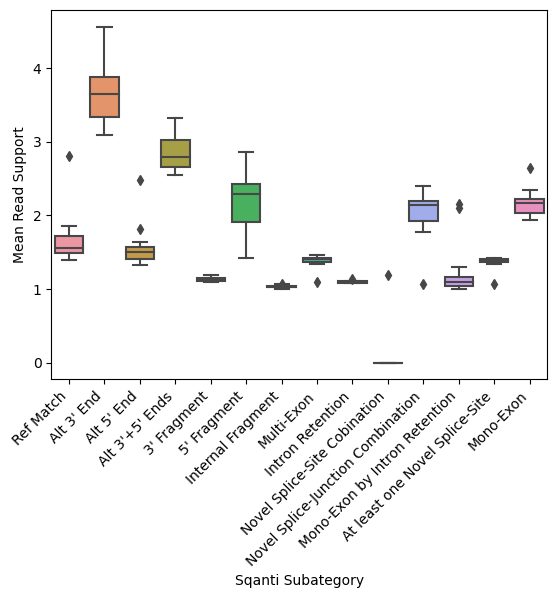

In [33]:
rs=sns.boxplot(all_reads_plot, x=0, y="value")
rs.set_xticklabels(col, rotation=45, horizontalalignment='right')
rs.set_ylabel("Mean Read Support")
rs.set_xlabel("Sqanti Subategory")

fig = rs.get_figure()
fig.savefig("read_support_subcats_pb.png", bbox_inches='tight')

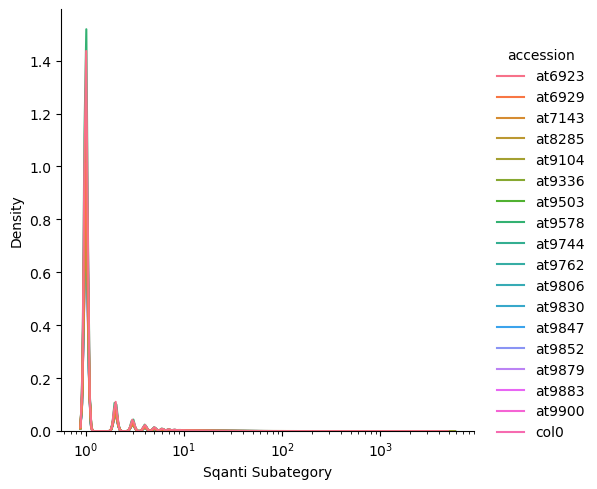

In [34]:
dist=sns.displot(ref, x="isoform_read_support",kind="kde",hue="accession", log_scale=True)
dist.set_axis_labels("Sqanti Subategory")

In [35]:
fig = dist.fig
fig.savefig("read_support_density_pb.png", bbox_inches='tight')

### Only read support >3

In [36]:
ref3=ref.loc[ref["isoform_read_support"]>3]

In [37]:
all_reads3=pd.DataFrame()
for acc in ref3["accession"].unique().tolist():    
    at=ref3.loc[(ref3["accession"]==acc)&~(ref3["structural_category"]=="fusion")]
    fus=ref3.loc[(ref3["accession"]==acc)&(ref3["structural_category"]=="fusion")]
    acc_out=pd.DataFrame(at.groupby(by=["subcategory"])["isoform_read_support"].apply("mean"))
    acc_out.loc["fusion"]=fus["isoform_read_support"].mean()
    acc_out.loc["accession"]=acc
    all_reads3=pd.concat([all_reads3,acc_out],axis=1)
all_reads3=all_reads3.fillna(0)

In [38]:
all_reads3=all_reads3.reset_index().T.reset_index()
all_reads3=all_reads3.drop("index",axis=1)
all_reads3.columns=all_reads3.iloc[0]
all_reads3=all_reads3.drop(all_reads3.index[0])

In [39]:
all_reads3_plot=all_reads3.melt(id_vars=["accession"], value_vars=order)

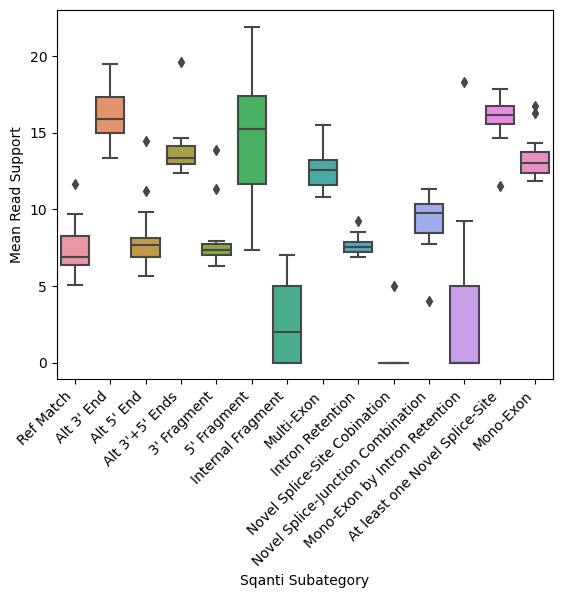

In [40]:
rs3=sns.boxplot(all_reads3_plot, x=0, y="value")
rs3.set_xticklabels(col, rotation=45, horizontalalignment='right')
rs3.set_ylabel("Mean Read Support")
rs3.set_xlabel("Sqanti Subategory")


fig = rs3.get_figure()
fig.savefig("read_support_3_subcats_pb.png", bbox_inches='tight')